# Microscopy figures
This [Jupyter](http://jupyter.com) notebook was used to help generate the microscopy figure for the [publication on the acinar complexity](https://www.authorea.com/274247/47HwqAxume3L2xkLOsg_SQ).
We grab the relevant original files from all over the place and copy them to a common, easily accessible folder.
Afterwards, we merge the original files for each 'modality' together and generate the final figure.

In [1]:
# Load the data and set up notebook
import matplotlib.pyplot as plt
# %matplotlib inline
import platform
import glob
import os
import pandas
import imageio
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import string

In [2]:
# Display all images in b&w and with 'nearest' interpolation
plt.rc('image', cmap='gray', interpolation='nearest')
# Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...
plt.rcParams['savefig.dpi'] = 300
# Transparend background for PNG images
plt.rcParams["savefig.transparent"] = True
# No padding
plt.rcParams['savefig.pad_inches'] = 0

Let's load the relevant data.
First we load the 'Count' data from Eveline.
This is what she assessed with the STEPanizer in tedious work.
This is the same as in the `Analysis.ipynb` notebook, so that we have the same file names ready.

In [3]:
# Different locations if running either on Linux or Windows
# ----
# We copied all the data 'nas_schittny' and 'anatera4' to the internal 'fast SSD' with
# ---
# rsync -av -m --include='**/' --include='**/*5slices/**' --exclude='*' '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/' '/media/habi/Fast_SSD/Acini/'
# (obviously only works on Linux)
# ---
# so we can set
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        RootPath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'Acini')
    else:
        RootPath = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny', 'doc', 'David')
else:
    if FastSSD:
        RootPath = os.path.join('F:/', 'Acini')
    else:
        RootPath = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data', 'doc', 'David')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [4]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    location_volumes = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    location_volumes = '\\\\anatera4\\'
# Load the data from this folder
terastation = location_volumes + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [5]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Fortunately, she did NOT count in 2018
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath,
                                                        '**/*201[1234567]*.xls'),
                                           recursive=True))

# STEPanizer
Get a sampler of the tomography slices to compare them with microscopy slides.
E.g., get *one* acinus per day, get the middle image of it and then image this *physical* slice on the microscope.
(We got the slices from Stefan...)
This if for the 'Comparison Images' at the end of the results.

In [6]:
Microscopy = pandas.DataFrame({'File': StepanizerFiles_Eveline})
Microscopy['Location'] = [os.path.dirname(f) for f in Microscopy.File]
Microscopy['NumImages'] = [len(glob.glob(os.path.join(f, '*.jpg'))) for f in Microscopy.Location]
Microscopy['MiddleImage'] = Microscopy.NumImages // 4  # we have _a and _b series, so half of it is the image set, and again half of it is the middle image
Microscopy['SelectedImage'] = [glob.glob(os.path.join(f,
                                                      '*' + str(mi) + '_a.jpg'))[0] for f, mi in zip(Microscopy.Location,
                                                                                                     Microscopy.MiddleImage)]
Microscopy['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in Microscopy.File]
Microscopy['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in Microscopy.File]
Microscopy['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in Microscopy.File]
Microscopy['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in Microscopy.File]

In [7]:
# from tqdm import tnrange, tqdm_notebook
# # get the random state
# for state in tqdm_notebook(range(188000, 10000000)):
#     Subset = Microscopy.groupby('Day').apply(lambda x: x.sample(random_state=state))
#     if all(Subset.isin({'Sample': ['R108C04At-mrg',
#                                    'R108C10C_B1_mrg',
#                                    'R108C21Bt-mrg',
#                                    'R108C60C_B1-mrg']})['Sample']):
# #         if all(Subset.isin({'Acinus': [39, 32, 38, 4]})['Acinus']):
#         print(state)

In [8]:
# Select one random sample per day (e.g. one random acinus)
# Based on https://stackoverflow.com/a/41566012/323100
# Define a random state so that we get a random sample, but the same random one every time we run this notebook.
Subset = Microscopy.groupby('Day').apply(lambda x: x.sample(random_state=8767799))
print('Image slices from these samples')
for c, i in Subset.iterrows():
    print('\t- From sample', i.Sample, 'we show Acinus\t', i.Acinus)

Image slices from these samples
	- From sample R108C04At-mrg we show Acinus	 38
	- From sample R108C10C_B1_mrg we show Acinus	 38
	- From sample R108C21Bt-mrg we show Acinus	 32
	- From sample R108C60C_B1-mrg we show Acinus	 4


# STEPanizer
The code below is used to copy the middle image of the STEPanizer dataset (see above on how we get this) to a common subfolder.

In [9]:
# Copy acinus images to STEPanizer subfolder
from shutil import copyfile
for c, s in Subset.iterrows():
    print('Copying %s to "STEPanizer" subfolder' % s.SelectedImage)
    copyfile(s.SelectedImage,
             os.path.join('Microscopy',
                          'STEPanizer',
                          os.path.basename(s.SelectedImage)))

Copying /media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At-mrg/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C04At-mrg-acinus38_6_a.jpg to "STEPanizer" subfolder
Copying /media/habi/Fast_SSD/Acini/2010c_tape/R108C10C_B1_mrg_10c/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C10C_B1_mrg-acinus38_15_a.jpg to "STEPanizer" subfolder
Copying /media/habi/Fast_SSD/Acini/2010a/mrg/R108C21Bt-mrg/acinus32/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C21Bt-mrg-acinus32_22_a.jpg to "STEPanizer" subfolder
Copying /media/habi/Fast_SSD/Acini/2010a/mrg/R108C60C_B1-mrg/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C60C_B1-mrg-acinus04_21_a.jpg to "STEPanizer" subfolder


# Microscopy
For *one* animal per day (selected randomly above) we imaged the middle slice of Stefans lung slices (usually slice nr. 8) on the microscope.
The code below is used to get the middle disector-slice and the bottom TOMCAT reconstruction of exactly these samples and copy them to the 'Microscopy' subfolder for generating the relevant figures.

In [10]:
for c, s in Subset.iterrows():
    print(s.SelectedImage)
    print(80 * '-')

/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At-mrg/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C04At-mrg-acinus38_6_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010c_tape/R108C10C_B1_mrg_10c/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C10C_B1_mrg-acinus38_15_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010a/mrg/R108C21Bt-mrg/acinus32/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C21Bt-mrg-acinus32_22_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010a/mrg/R108C60C_B1-mrg/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C60C_B1-mrg-acinus04_21_a.jpg
--------------------------------------------------------------------------------


# Microscopy
For *one* animal per day (selected randomly above) we imaged the middle slice of Stefans lung slices (usually slice nr. 8) on the microscope.

In [11]:
for c, s in Subset.iterrows():
    print('Image slices 8 of %s under the microscope' % s.Sample)

Image slices 8 of R108C04At-mrg under the microscope
Image slices 8 of R108C10C_B1_mrg under the microscope
Image slices 8 of R108C21Bt-mrg under the microscope
Image slices 8 of R108C60C_B1-mrg under the microscope


The slices were imaged under the microscope and saved as TIF files and JPG with scale bar.
The 200 um long scale bar was measured in ImageJ: 1.85 pixels/um --> 0.54 um/px.
The TIFFs were color-corrected with https://github.com/pmascalchi/ImageJ_Auto-white-balance-correction and saved to a new subfolder.

# TOMCAT
The code below is used to get the bottom TOMCAT reconstruction (largest part of parenchyma in the image) of the chosen samples and copy them to the 'TOMCAT' subfolder.

In [12]:
# Copy bottom reconstruction of top scan from selected sample to Microscopy subfolder
for c, s in Subset.iterrows():
    # Do some string manipulation to get us the correct directory
    lookuppath = terastation + os.path.join(os.path.dirname(os.path.dirname(s.Location[len(RootPath):])),
                                            'rec_8bit*')
    # Get all the files in there, sorted
    files = sorted(glob.glob(os.path.join(lookuppath,
                                          '*.tif')))
    # The last file is the bottom image of the top stack, copy this one, now
    print('Copying %s to "TOMCAT" subfolder' % files[-1])
    copyfile(files[-1],
             os.path.join('Microscopy',
                          'TOMCAT',
                          os.path.basename(files[-1])))

Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010a/mrg/R108C04At-mrg/rec_8bit/R108C04At-mrg1024.rec.8bit.tif to "TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010c_tape/R108C10C_B1_mrg_10c/rec_8bit/R108C10C_B1_mrg1024.rec.8bit.tif to "TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010a/mrg/R108C21Bt-mrg/rec_8bit_/R108C21Bt-mrg1024.rec.8bit.tif to "TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010a/mrg/R108C60C_B1-mrg/rec_8bit/R108C60C_B1-mrg1024.rec.8bit.tif to "TOMCAT" subfolder


These square images were all loaded in ImageJ, rotated in such a way that the tissue is horizontal and cropped to a common size.
Then I enhanced the contrast in ImageJ (0.3% saturated pixels, normalize).
The images were then saved out as PNG images.

# Figure
Now that we're done with copying the data around, we can generate the figure

In [13]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'black'

In [14]:
# color-corrected the microscopy TIFFs with https://github.com/pmascalchi/ImageJ_Auto-white-balance-correction
# scalebar from microscopy sliced measured in ImageJ: 1.85 pixels/um --> 0.54 um/px

In [15]:
# Set pixel sizes, for scalebar
pixelsizemicroscopy = 0.54
pixelsizetomcat = 1.48

In [16]:
# Read the microscopy slides
mic04 = imageio.imread(glob.glob(os.path.join('Microscopy', 'Slides', '*background*', 'R108C04*.tif'))[0])
mic10 = imageio.imread(glob.glob(os.path.join('Microscopy', 'Slides', '*background*', 'R108C10*.tif'))[0])
mic21 = imageio.imread(glob.glob(os.path.join('Microscopy', 'Slides', '*background*', 'R108C21*.tif'))[0])
mic60 = imageio.imread(glob.glob(os.path.join('Microscopy', 'Slides', '*background*', 'R108C60*.tif'))[0])

In [17]:
# Read the TOMCAT reconstructions
tomcat04 = imageio.imread(glob.glob(os.path.join('Microscopy', 'TOMCAT', 'R108C04*.contrast*.png'))[0])
tomcat10 = imageio.imread(glob.glob(os.path.join('Microscopy', 'TOMCAT', 'R108C10*.contrast*.png'))[0])
tomcat21 = imageio.imread(glob.glob(os.path.join('Microscopy', 'TOMCAT', 'R108C21*.contrast*.png'))[0])
tomcat60 = imageio.imread(glob.glob(os.path.join('Microscopy', 'TOMCAT', 'R108C60*.contrast*.png'))[0])

In [18]:
# Read the STEPanizer files
stepanizer04 = imageio.imread(glob.glob(os.path.join('Microscopy', 'STEPanizer', 'R108C04*.jpg'))[0])
stepanizer10 = imageio.imread(glob.glob(os.path.join('Microscopy', 'STEPanizer', 'R108C10*.jpg'))[0])
stepanizer21 = imageio.imread(glob.glob(os.path.join('Microscopy', 'STEPanizer', 'R108C21*.jpg'))[0])
stepanizer60 = imageio.imread(glob.glob(os.path.join('Microscopy', 'STEPanizer', 'R108C60*.jpg'))[0])

The STEPanizer slices have been padded to squares by my aeons-old MATLAB script.
For display reasons we get rid of this white border, and center all the images in a square with the side length of the largest axis of all images.

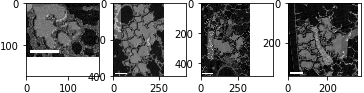

In [19]:
# Show originals
plt.subplot(141)
plt.imshow(stepanizer04)
plt.subplot(142)
plt.imshow(stepanizer10)
plt.subplot(143)
plt.imshow(stepanizer21)
plt.subplot(144)
plt.imshow(stepanizer60)
plt.show()

In [20]:
def crop_border(image, verbose=False):
    """
    Based on https://stackoverflow.com/a/11188955/323100
    """
    # Due to JPG compression we don't use pure white (255), but look for rows/colums where every pixel is above 222
    # right border
    crop = image.compress(~numpy.all(image > 222,
                                     axis=0),
                          axis=1)
    # bottom border
    crop = crop.compress(~numpy.all(crop > 222,
                                    axis=1),
                         axis=0)
    if verbose:
        plt.subplot(121)
        plt.imshow(image)
        plt.subplot(122)
        plt.imshow(crop)
        plt.show()
    return(crop)

In [21]:
# Crop borders
stepanizer04 = crop_border(stepanizer04)
stepanizer10 = crop_border(stepanizer10)
stepanizer21 = crop_border(stepanizer21)
stepanizer60 = crop_border(stepanizer60)

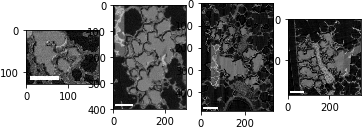

In [22]:
# Show cropped
plt.subplot(141)
plt.imshow(stepanizer04)
plt.subplot(142)
plt.imshow(stepanizer10)
plt.subplot(143)
plt.imshow(stepanizer21)
plt.subplot(144)
plt.imshow(stepanizer60)
plt.show()

In [23]:
# Pad the STEPanizer images to an equal size
# Get the biggest x or y length
size = 0
for s in stepanizer04, stepanizer10, stepanizer21, stepanizer60:
    size = max(size, numpy.shape(s)[0], numpy.shape(s)[1])
# Pad all STEPanizer images to this size
# We might loose a pixel on one side due to the integer division, but noone will care :)
backgroundgrayvalue = 245
stepanizer04 = numpy.pad(stepanizer04,
                         (((size - numpy.shape(stepanizer04)[0]) // 2,
                           (size - numpy.shape(stepanizer04)[0]) // 2),
                          ((size - numpy.shape(stepanizer04)[1]) // 2,
                           (size - numpy.shape(stepanizer04)[1]) // 2)),
                         'constant',
                         constant_values=backgroundgrayvalue)
stepanizer10 = numpy.pad(stepanizer10,
                         (((size - numpy.shape(stepanizer10)[0]) // 2,
                           (size - numpy.shape(stepanizer10)[0]) // 2),
                          ((size - numpy.shape(stepanizer10)[1]) // 2,
                           (size - numpy.shape(stepanizer10)[1]) // 2)),
                         'constant',
                         constant_values=backgroundgrayvalue)
stepanizer21 = numpy.pad(stepanizer21,
                         (((size - numpy.shape(stepanizer21)[0]) // 2,
                           (size - numpy.shape(stepanizer21)[0]) // 2),
                          ((size - numpy.shape(stepanizer21)[1]) // 2,
                           (size - numpy.shape(stepanizer21)[1]) // 2)),
                         'constant',
                         constant_values=backgroundgrayvalue)
stepanizer60 = numpy.pad(stepanizer60,
                         (((size - numpy.shape(stepanizer60)[0]) // 2,
                           (size - numpy.shape(stepanizer60)[0]) // 2),
                          ((size - numpy.shape(stepanizer60)[1]) // 2,
                           (size - numpy.shape(stepanizer60)[1]) // 2)),
                         'constant',
                         constant_values=backgroundgrayvalue)

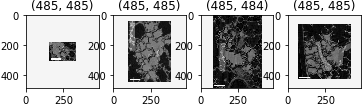

In [24]:
plt.subplot(141)
plt.imshow(stepanizer04)
plt.title(numpy.shape(stepanizer04))
plt.subplot(142)
plt.imshow(stepanizer10)
plt.title(numpy.shape(stepanizer10))
plt.subplot(143)
plt.imshow(stepanizer21)
plt.title(numpy.shape(stepanizer21))
plt.subplot(144)
plt.imshow(stepanizer60)
plt.title(numpy.shape(stepanizer60))
plt.show()

We struggled for several hours to make *one* subfigure in one go without any borders around the image.
The workaround is to save each 'modality' as single image (after adding scale bars), write these out to single images, read them in, concatenate and save out again.
Not nice, but works :)

In [25]:
def image_label(image, labeltext, color='black', boxcolor='white'):
    '''We have to print a label over the image several times'''
    t = plt.gca().text(numpy.shape(image)[1] * 0.0309,
                       numpy.shape(image)[0] * 0.0309,
                       labeltext,
                       color=color,
                       fontsize=12,
                       verticalalignment='top',
                       horizontalalignment='left')
    if boxcolor is not None:
        t.set_bbox(dict(facecolor=boxcolor,
                        edgecolor=boxcolor,
                        alpha=0.618))
    return

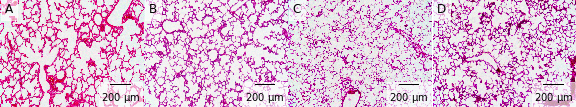

In [26]:
# Microscopy
plt.rcParams['figure.figsize'] = (8, 4 * 8 / (numpy.shape(mic04)[0] / numpy.shape(mic04)[1]))
for c, img in enumerate((mic04, mic10, mic21, mic60)):
    plt.subplot(3, 4, c + 1)
    plt.imshow(img)
    plt.gca().add_artist(ScaleBar(pixelsizemicroscopy,
                                  'um',
                                  frameon=True,
                                  box_color='white',
                                  box_alpha=0.618))
    plt.gca().set_axis_off()
    # Minimize white space around the subplots
    # based on https://stackoverflow.com/a/27227718/323100
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    image_label(img, string.ascii_uppercase[c])
plt.subplots_adjust(top=1, bottom=0,
                    right=1, left=0,
                    hspace=0.005, wspace=0.005)
plt.savefig(os.path.join('Microscopy', 'microscopy.png'),
            bbox_inches='tight',
            pad_inches=0)

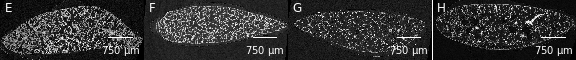

In [27]:
# TOMCAT
plt.rcParams['figure.figsize'] = (8, 4 * 8 / (numpy.shape(tomcat04)[0] / numpy.shape(tomcat04)[1]))
for c, img in enumerate((tomcat04, tomcat10, tomcat21, tomcat60)):
    plt.subplot(3, 4, c + 1)
    plt.imshow(img)
    plt.gca().add_artist(ScaleBar(pixelsizetomcat,
                                  'um',
                                  color='white'))
    plt.gca().set_axis_off()
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    image_label(img,
                string.ascii_uppercase[c + 4],
                color='white',
                boxcolor=None)
plt.subplots_adjust(top=1, bottom=0,
                    right=1, left=0,
                    hspace=0.005, wspace=0.005)
plt.savefig(os.path.join('Microscopy', 'tomcat.png'),
            bbox_inches='tight',
            pad_inches=0)

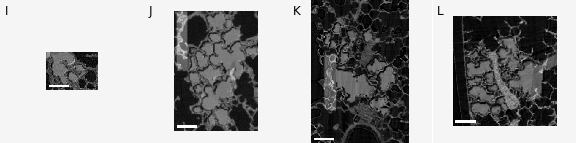

In [28]:
# STEPanizer
plt.rcParams['figure.figsize'] = (8, 4 * 8 / (numpy.shape(stepanizer04)[0] / numpy.shape(stepanizer04)[1]))
for c, img in enumerate((stepanizer04, stepanizer10, stepanizer21, stepanizer60)):
    plt.subplot(3, 4, c + 1)
    plt.imshow(img)
    plt.gca().set_axis_off()
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    image_label(img,
                string.ascii_uppercase[c + 8],
                boxcolor=None)
plt.subplots_adjust(top=1, bottom=0,
                    right=1, left=0,
                    hspace=0.005, wspace=0.005)
plt.savefig(os.path.join('Microscopy', 'stepanizer.png'),
            bbox_inches='tight',
            pad_inches=0)

In [29]:
# Read the three rows in again
mic = imageio.imread(os.path.join('Microscopy', 'microscopy.png'))
tomcat = imageio.imread(os.path.join('Microscopy', 'tomcat.png'))
stepanizer = imageio.imread(os.path.join('Microscopy', 'stepanizer.png'))

In [30]:
# Remove the intermediate files
os.remove(os.path.join('Microscopy', 'microscopy.png'))
os.remove(os.path.join('Microscopy', 'tomcat.png'))
os.remove(os.path.join('Microscopy', 'stepanizer.png'))

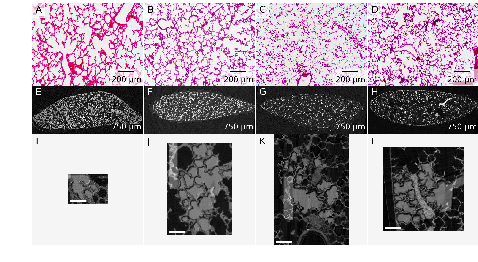

In [31]:
# Concatenate and save out again
concatenate = numpy.concatenate((mic, tomcat, stepanizer), axis=0)
plt.imshow(concatenate)
plt.axis('off')
plt.show()
imageio.imwrite(os.path.join('Microscopy',
                             'Fig01.png'),
                concatenate)